# 1. 라이브러리 로드

In [1]:
import pandas as pd
import numpy as np
import re
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager as fm
import matplotlib as mpl
plt.rcParams['font.family'] = 'Malgun Gothic'
rc={'axes.labelsize': 15, 'font.size': 15, 'legend.fontsize': 12.0, 'axes.titlesize': 20}
plt.rcParams.update(**rc)
mpl.rcParams['axes.unicode_minus'] = False
os.getcwd()

'D:\\kaggle\\ELO'

# 2. 데이터 로드
* train.csv: 학습 데이터
* test.csv: 테스트 데이터

* sample_submission.csv: 제출 예시 데이터

* historical_transactions.csv: 상인 거래 데이터(3개월)
* new_merchant_transactions.csv: 상인 거래 데이터(2개월) 

* merchants.csv: 상인관련 지표 데이터

* Data_Dictionary.xlsx: 데이터 설명 엑셀

In [2]:
%%time
train=pd.read_csv("D:/kaggle/ELO/data/train.csv",encoding='utf-8')
test=pd.read_csv("D:/kaggle/ELO/data/test.csv",encoding='utf-8')

sample_sub=pd.read_csv("D:/kaggle/ELO/data/sample_submission.csv",encoding='utf-8')

history_trans=pd.read_csv("D:/kaggle/ELO/data/historical_transactions.csv",encoding='utf-8')
new_trans=pd.read_csv("D:/kaggle/ELO/data/new_merchant_transactions.csv",encoding='utf-8')

merchant=pd.read_csv("D:/kaggle/ELO/data/merchants.csv",encoding='utf-8')

Wall time: 57.7 s


In [3]:
train_dic=pd.read_excel("D:/kaggle/ELO/data/Data_Dictionary.xlsx",sheet_name = 'train')
his_dic=pd.read_excel("D:/kaggle/ELO/data/Data_Dictionary.xlsx",sheet_name = 'history')
new_trans_dic=pd.read_excel("D:/kaggle/ELO/data/Data_Dictionary.xlsx",sheet_name = 'new_merchant_period')
merchant_dic=pd.read_excel("D:/kaggle/ELO/data/Data_Dictionary.xlsx",sheet_name = 'merchant')

# 3. EDA
## 1. train/test

In [4]:
train.head()
#train.info()

#test.head()
#test.info()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


### 전체 데이터 행/열 확인

In [5]:
print("------------전체 데이터 행/열 개수 확인------------")
print("train         : {} ".format(train.shape))
print("test          : {} ".format(test.shape))
print("history_trans : {} ".format(history_trans.shape))
print("new_trans     : {} ".format(new_trans.shape))
print("-----------------------------------------")

------------전체 데이터 행/열 개수 확인------------
train         : (201917, 6) 
test          : (123623, 5) 
history_trans : (29112361, 14) 
new_trans     : (1963031, 14) 
-----------------------------------------


### card_id 포함 관계 확인

In [6]:
############################ Set(집합) 다루기 ############################ 
##  1. 합집합 (|)
##  2. 차집합 (-)
##  3. 교집합 (&)
##########################################################################

In [7]:
### unique card_id
train_id=set(np.unique(train.card_id))
test_id=set(np.unique(test.card_id))
history_trans_id=set(np.unique(history_trans.card_id))
new_trans_id=set(np.unique(new_trans.card_id))
traintest_id=train_id|test_id 
print("------------ unique card_id 개수 확인------------")
print("train_id           : {} 개".format(len(train_id)))
print("test_id            : {} 개".format(len(test_id)))
print("train+test         : {} 개".format(len(traintest_id)))
print()
print("history_trans_id   : {} 개".format(len(history_trans_id)))
print("new_trans_id       : {} 개".format(len(new_trans_id)))
print("-------------------------------------------------")

------------ unique card_id 개수 확인------------
train_id           : 201917 개
test_id            : 123623 개
train+test         : 325540 개

history_trans_id   : 325540 개
new_trans_id       : 290001 개
-------------------------------------------------


In [8]:
### intersect card_id
print("------------ card_id 포함 관계 확인------------")
print("# 중복(포함)없음 - 배반관계")
print("train         ∩   test          : {} 개".format(len(train_id&test_id)))              # 중복 없음
print()
print("### train+test  ⊂   history_trans ###")
print("train         ∩   history_trans : {} 개".format(len(train_id&history_trans_id)))     # train      ⊂ history_trans 
print("test          ∩   history_trans : {} 개".format(len(test_id&history_trans_id)))      # test       ⊂ history_trans 
print("train+test    ∩   history_trans : {} 개".format(len(traintest_id&history_trans_id))) # train+test ⊂history_trans 
print() 

print("### train+test  ⊂   new_trans ###")
print("train         ∩   new_trans     : {} 개".format(len(train_id&new_trans_id)))         # train      ⊂ new_trans 
print("test          ∩   new_trans     : {} 개".format(len(test_id&new_trans_id)))          # test       ⊂ new_trans 
print("train+test    ∩   new_trans     : {} 개".format(len(traintest_id&new_trans_id)))     # train+test ⊂ new_trans 
print()

print("### new_trans   ⊂ history_trans ###")
print("history_trans ∩ new_trans       : {} 개".format(len(history_trans_id&new_trans_id))) # new_trans  ⊂ history_trans
print("------------------------------------------------")

------------ card_id 포함 관계 확인------------
# 중복(포함)없음 - 배반관계
train         ∩   test          : 0 개

### train+test  ⊂   history_trans ###
train         ∩   history_trans : 201917 개
test          ∩   history_trans : 123623 개
train+test    ∩   history_trans : 325540 개

### train+test  ⊂   new_trans ###
train         ∩   new_trans     : 179986 개
test          ∩   new_trans     : 110015 개
train+test    ∩   new_trans     : 290001 개

### new_trans   ⊂ history_trans ###
history_trans ∩ new_trans       : 290001 개
------------------------------------------------


### transaction(history, new) 데이터 병합 → history+new = all_trans

In [9]:
### 병합전 기간 중복 여부 확인
print("### 기간 중복 없으므로 행 병합 가능 ###")
print("history_trans 기간 : {} ~ {}".format(min(history_trans.purchase_date),max(history_trans.purchase_date)))
print("new_trans     기간 : {} ~ {}".format(min(new_trans.purchase_date),max(new_trans.purchase_date)))

### 기간 중복 없으므로 행 병합 가능 ###
history_trans 기간 : 2017-01-01 00:00:08 ~ 2018-02-28 23:59:51
new_trans     기간 : 2017-03-01 03:24:51 ~ 2018-04-30 23:59:59


In [10]:
### all_trans로 병합
all_trans=pd.concat([history_trans,new_trans]).reset_index(drop=True)
all_trans=pd.merge(all_trans,train,on=['card_id'],how='left')
all_trans.tail()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,first_active_month,feature_1,feature_2,feature_3,target
31075387,Y,C_ID_1320dee851,142,N,0,A,309,M_ID_7754b67f3b,2,-0.701828,2018-04-06 14:36:52,3.0,19,21,NaN,NaN,NaN,NaN,NaN
31075388,Y,C_ID_f112aa3381,158,N,0,A,560,M_ID_da063195b7,2,-0.694390,2018-03-07 13:19:18,1.0,15,34,2016-10,3.0,2.0,1.0,2.457150
31075389,Y,C_ID_bd97b86450,69,N,1,B,278,M_ID_9a9ccb6544,1,-0.621031,2018-03-05 12:04:56,1.0,9,37,2017-09,4.0,3.0,0.0,0.360656
31075390,Y,C_ID_c0513fd84f,130,N,0,A,367,M_ID_40c28d596f,1,-0.656749,2018-03-09 14:47:05,3.0,7,16,2016-07,2.0,2.0,0.0,-1.680951
31075391,Y,C_ID_a935410f8e,19,N,0,A,278,M_ID_d855771cd9,2,-0.739395,2018-04-11 07:59:46,1.0,9,37,2017-04,2.0,2.0,0.0,4.568632


In [11]:
all_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31075392 entries, 0 to 31075391
Data columns (total 19 columns):
authorized_flag         object
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           object
category_2              float64
state_id                int64
subsector_id            int64
first_active_month      object
feature_1               float64
feature_2               float64
feature_3               float64
target                  float64
dtypes: float64(6), int64(6), object(7)
memory usage: 4.6+ GB


In [12]:
#target이 NA인 11825698개의 행은 card_id가 test에 있으므로 target이 있을 수가 없다
all_trans.target.isna().sum()

11825698

In [13]:
## target에 NaN있는건 test쪽 card_id를 가진 데이터임 이거 빼주고 변수들과 target과의 관계를 확인할 준비
all_trans=all_trans.loc[all_trans.target.isna()==False]
print(len(all_trans))
print(all_trans.target.isna().sum())

19249694
0


In [14]:
all_trans.tail(3)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,first_active_month,feature_1,feature_2,feature_3,target
31075389,Y,C_ID_bd97b86450,69,N,1,B,278,M_ID_9a9ccb6544,1,-0.621031,2018-03-05 12:04:56,1.0,9,37,2017-09,4.0,3.0,0.0,0.360656
31075390,Y,C_ID_c0513fd84f,130,N,0,A,367,M_ID_40c28d596f,1,-0.656749,2018-03-09 14:47:05,3.0,7,16,2016-07,2.0,2.0,0.0,-1.680951
31075391,Y,C_ID_a935410f8e,19,N,0,A,278,M_ID_d855771cd9,2,-0.739395,2018-04-11 07:59:46,1.0,9,37,2017-04,2.0,2.0,0.0,4.568632


In [161]:
# 한 ID에 2915행 있는 건 나중에 모델 만들때 2915개 행중 어떤걸 학습용으로 써야하나...
all_trans.card_id.value_counts()

C_ID_0cd2ce025c    2915
C_ID_cc3d4cd4e3    2192
C_ID_5ccc07beb9    2072
C_ID_5ea401d358    1786
C_ID_9f81506906    1672
                   ... 
C_ID_1e3c6b4f44       2
C_ID_8541cd1c9d       2
C_ID_22df161ffe       2
C_ID_5739df8607       2
C_ID_2863d2fa95       2
Name: card_id, Length: 201917, dtype: int64

In [54]:
### category_3 / merchant_id / category_2의 na 존재
all_trans.isna().sum()

authorized_flag               0
card_id                       0
city_id                       0
category_1                    0
installments                  0
category_3               145197
merchant_category_id          0
merchant_id              102297
month_lag                     0
purchase_amount               0
purchase_date                 0
category_2              1706443
state_id                      0
subsector_id                  0
first_active_month            0
feature_1                     0
feature_2                     0
feature_3                     0
target                        0
dtype: int64

In [59]:
### 일반 na 값들 대충 처리
all_trans.category_3.fillna(999,inplace=True)
all_trans.category_2.fillna(999,inplace=True)

In [60]:
all_trans.isna().sum()

authorized_flag              0
card_id                      0
city_id                      0
category_1                   0
installments                 0
category_3                   0
merchant_category_id         0
merchant_id             102297
month_lag                    0
purchase_amount              0
purchase_date                0
category_2                   0
state_id                     0
subsector_id                 0
first_active_month           0
feature_1                    0
feature_2                    0
feature_3                    0
target                       0
dtype: int64

In [62]:
### catgory_2 /  feature_1,2,3 은 categorical이므로 int형으로 전환
# category_2의 경우, na 존재하므로 
all_trans['category_2']=all_trans['category_2'].astype(int)
all_trans['feature_1']=all_trans['feature_1'].astype(int)
all_trans['feature_2']=all_trans['feature_1'].astype(int)
all_trans['feature_3']=all_trans['feature_1'].astype(int)
all_trans.tail(3)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,first_active_month,feature_1,feature_2,feature_3,target
31075389,Y,C_ID_bd97b86450,69,N,1,B,278,M_ID_9a9ccb6544,1,-0.621031,2018-03-05 12:04:56,1,9,37,2017-09,4,4,4,0.360656
31075390,Y,C_ID_c0513fd84f,130,N,0,A,367,M_ID_40c28d596f,1,-0.656749,2018-03-09 14:47:05,3,7,16,2016-07,2,2,2,-1.680951
31075391,Y,C_ID_a935410f8e,19,N,0,A,278,M_ID_d855771cd9,2,-0.739395,2018-04-11 07:59:46,1,9,37,2017-04,2,2,2,4.568632


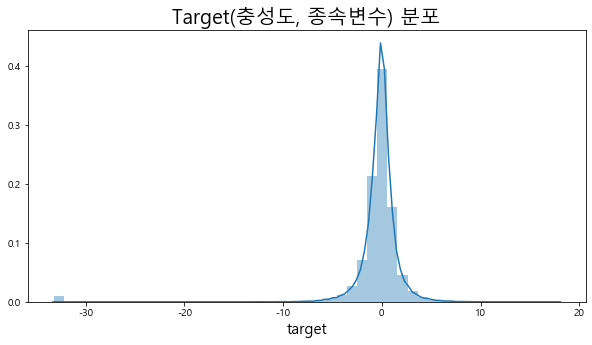

In [64]:
### target 분포 확인 
plt.figure(figsize=(10,5))
plt.title("Target(충성도, 종속변수) 분포",size=20)
sns.distplot(all_trans.target)

In [65]:
print('-30 이하 target 값은 {} 개.'.format(len(train.loc[train.target < -30])))

-30 이하 target 값은 2207 개.


### 각 변수와 target 간의 관계확인
#### 1.categorical : authorized_flag / city_id / category_1,2,3 / state_id / subsector_id /  / feature_1,2,3
#### 2.numerical : installments / month_lag / purchase_amount 
#### 3.datetime : purchase_date / first_active_month / first_active_month

<br>

* categorical 변수: 각 카테고리에 대한 target 평균값 확인(countplot)
* numerical 변수: 각 변수에 따른 분포 확인(scatterplot)
* datetime 관련 변수는 년/월/일등으로 분해해서 보기

## 대부분의 categorical 변수들의 충성도가 음수인 이유 
* target이 -30인 2207개의 값들이 평균에 영향을 미쳐 변수 대부분의 충성도가 -값이 됨, 이것에 대한 전처리 고민 필요하다

### 1. target_mean ~ authorized_flag

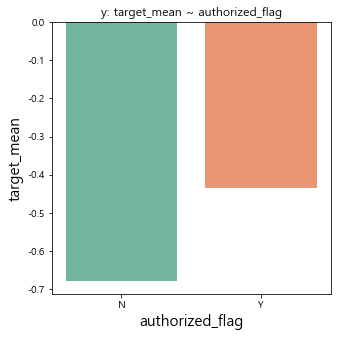

In [191]:
# 평균값 자체는 y,n 둘다 충성도 낮음
# 그나마 y가 더 높음
plt.figure(figsize=(5,5))

target_by_authorized_flag=pd.DataFrame({"authorized_flag":all_trans.groupby('authorized_flag').target.mean().index,
                                        "target_mean":all_trans.groupby('authorized_flag').target.mean().values})
plt.title('y: target_mean ~ authorized_flag',size=12)
sns.barplot(data=target_by_authorized_flag,x='authorized_flag',y=('target_mean'),palette='Set2')

### 2. target_mean ~ city_id

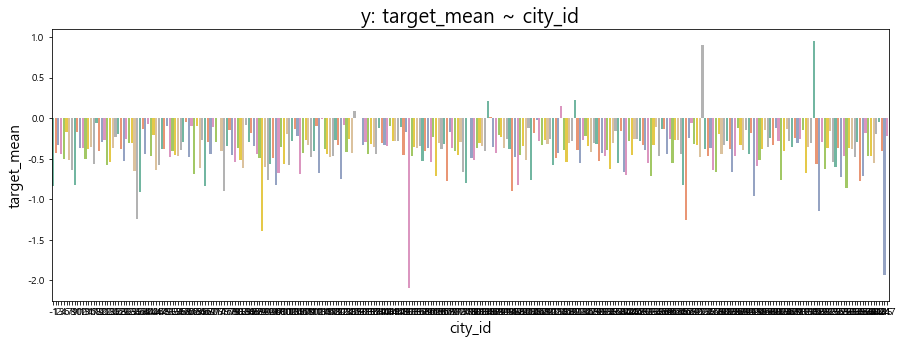

In [184]:
# 몇몇 city를 제외하고 평균 값이 다 음수
plt.figure(figsize=(15,5))
target_by_city_id=pd.DataFrame({"city_id":all_trans.groupby('city_id').target.mean().index,
                                        "target_mean":all_trans.groupby('city_id').target.mean().values})
plt.title('y: target_mean ~ city_id')
sns.barplot(data=target_by_city_id,x='city_id',y=('target_mean'),palette='Set2')

In [185]:
all_trans.groupby('city_id').target.mean().sort_values(ascending=False)[0:15]

city_id
316    0.949453
273    0.904335
221    0.230438
185    0.208876
215    0.158199
128    0.085884
186    0.020172
178    0.007679
129    0.003892
130    0.003735
73     0.001298
114   -0.005786
206   -0.020159
343   -0.040263
58    -0.042491
Name: target, dtype: float64

### 3. target_mean ~ category_1,2,3

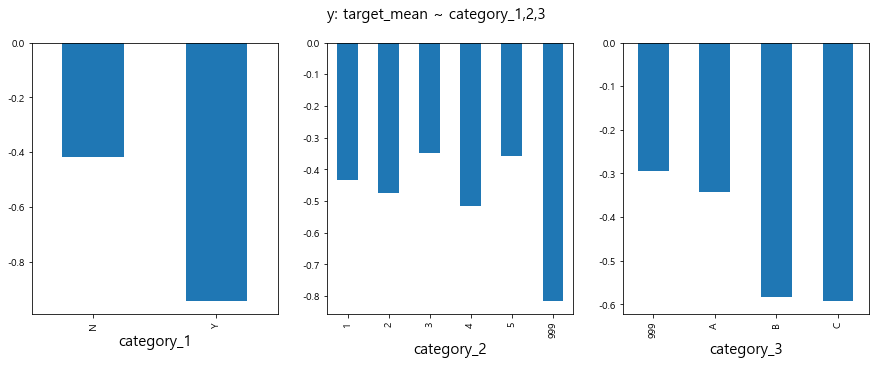

In [186]:
# 모두 충성도 낮음;;;;;
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle('y: target_mean ~ category_1,2,3',size=15)
all_trans.groupby(['category_1']).target.mean().plot(kind='bar',ax=ax[0])
all_trans.groupby(['category_2']).target.mean().plot(kind='bar',ax=ax[1])
all_trans.groupby(['category_3']).target.mean().plot(kind='bar',ax=ax[2])

### 4. target_mean ~ state_id

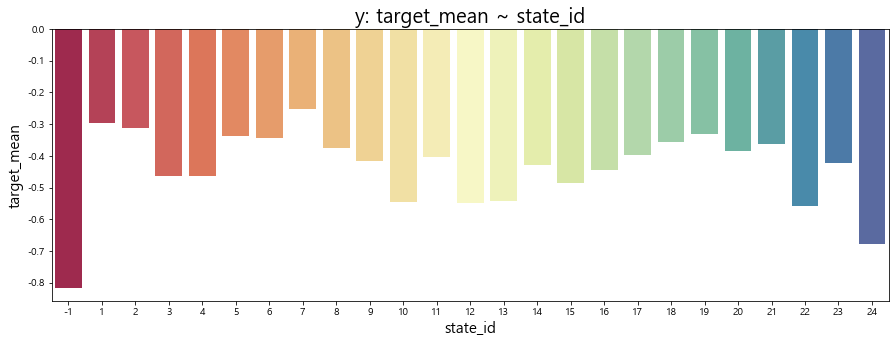

In [187]:
# 모두 충성도 낮음;;;;;
plt.figure(figsize=(15,5))
target_by_state_id=pd.DataFrame({"state_id":all_trans.groupby('state_id').target.mean().index,
                                 "target_mean":all_trans.groupby('state_id').target.mean().values})
plt.title('y: target_mean ~ state_id')
sns.barplot(data=target_by_state_id,x='state_id',y=('target_mean'),palette='Spectral')

### 5. target_mean ~ subsector_id

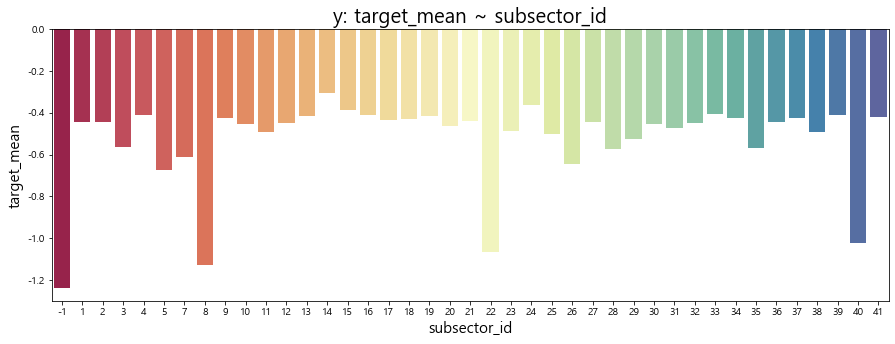

In [188]:
# 모두 충성도 낮음;;;;;
plt.figure(figsize=(15,5))
target_by_subsector_id=pd.DataFrame({"subsector_id":all_trans.groupby('subsector_id').target.mean().index,
                                     "target_mean":all_trans.groupby('subsector_id').target.mean().values})
plt.title('y: target_mean ~ subsector_id')
sns.barplot(data=target_by_subsector_id,x='subsector_id',y=('target_mean'),palette='Spectral')

### 6. target_mean ~ feature_1,2,3

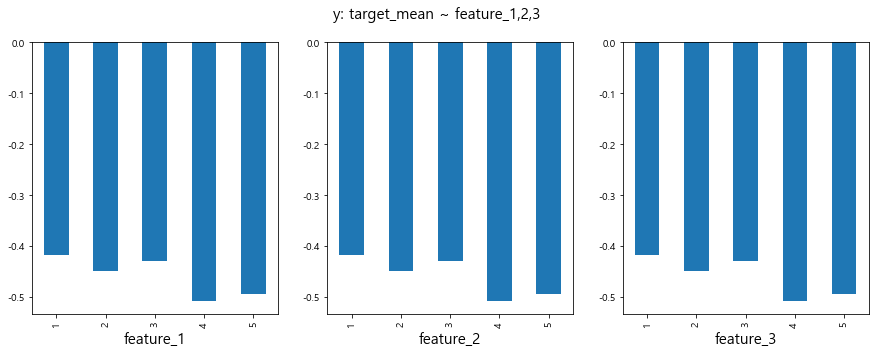

In [189]:
# 모두 충성도 낮음;;;;;
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle('y: target_mean ~ feature_1,2,3',size=15)
all_trans.groupby(['feature_1']).target.mean().plot(kind='bar',ax=ax[0])
all_trans.groupby(['feature_2']).target.mean().plot(kind='bar',ax=ax[1])
all_trans.groupby(['feature_3']).target.mean().plot(kind='bar',ax=ax[2])

### 7. target ~ installments

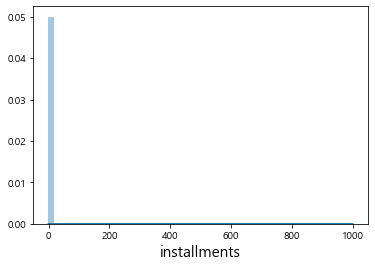

In [202]:
# 이상치 999 때문에 기본 분포 잘 안보임
sns.distplot(all_trans.installments) 

In [ ]:
### 12이하까지만 처리
all_trans_install_fix=all_trans.loc[all_trans.installments<13]
sns.distplot(all_trans_install_fix.installments)

Text(0.5, 1.0, 'y: target_mean ~ installments_mean')

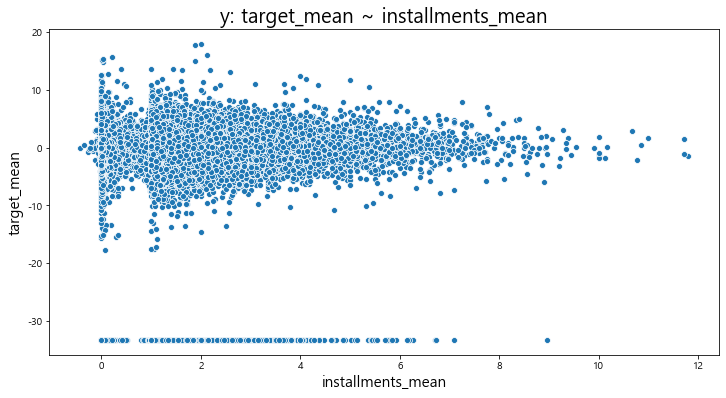

In [212]:
### 한 card_id에 여러 installment가 걸리므로 평균으로 재처리
# installments 가 커질수록.... target이 0에 수렴? 의미 없어보임...
plt.figure(figsize=(12,6))
temp_installments=all_trans_install_fix.groupby('card_id').aggregate({'installments':'mean','target':'mean'})
temp_installments.columns=['installments_mean','target_mean']
sns.scatterplot(data=temp_installments,
                x='installments_mean',y='target_mean')
plt.title('y: target_mean ~ installments_mean')

### 8. target ~ month_lag

Text(0.5, 1.0, 'y: target_mean ~ month_lag_mean')

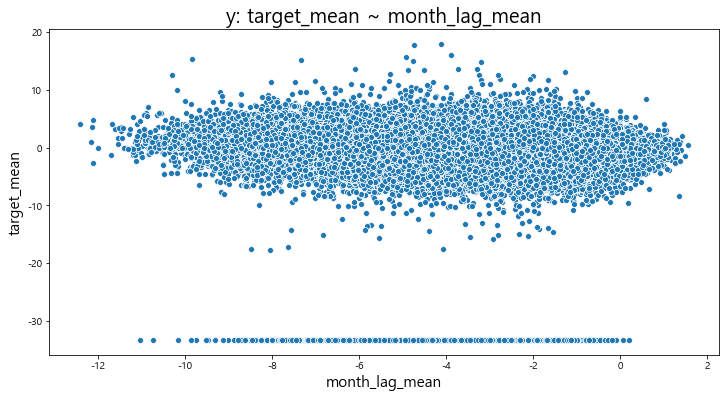

In [215]:
### 한 card_id에 여러 month_lag이 걸리므로 평균으로 재처리
# month_lag 가 커질수록.... target이 0에 수렴? 의미 없어보임...
plt.figure(figsize=(12,6))
temp_month_lag=all_trans_install_fix.groupby('card_id').aggregate({'month_lag':'mean','target':'mean'})
temp_month_lag.columns=['month_lag_mean','target_mean']
sns.scatterplot(data=temp_month_lag,
                x='month_lag_mean',y='target_mean')
plt.title('y: target_mean ~ month_lag_mean')

In [ ]:
############# 코드 에러 일시중단 ###################

### 9. target ~ purchase_amount

In [218]:
print(min(all_trans.purchase_amount),max(all_trans.purchase_amount))

-0.7469078 6010603.9717525


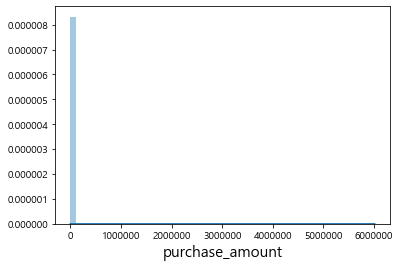

In [220]:
## 10만 이하에 대다수 분포하므로 10만 이하만 처리
sns.distplot(all_trans.purchase_amount)

In [ ]:
### purchase_amount의 경우 
### 1.총 구매량에 대한 합 기준 
### 2.다른 통계량(평균,중앙값 등) 의 추가 고민 가능... 일단 sum이랑 mean만
### -- target 은 그대로 mean

## 1. sum 기준 
all_trans_puchase_amount_fix_sum=all_trans.loc[all_trans.purchase_amount<100000]
plt.figure(figsize=(12,6))
temp_puchase_amount_sum=all_trans_puchase_amount_fix_sum.groupby('card_id').aggregate({'purchase_amount':'sum','target':'mean'})
temp_puchase_amount_sum.columns=['purchase_amount_sum','target_mean']
sns.scatterplot(data=temp_puchase_amount_sum,
                x='purchase_amount_sum',y='target_mean')
plt.title('y: purchase_amount_sum ~ month_lag_mean')

In [ ]:
## 2. mean 기준 
all_trans_puchase_amount_fix_sum=all_trans.loc[all_trans.purchase_amount<100000]
plt.figure(figsize=(12,6))
temp_puchase_amount_sum=all_trans_puchase_amount_fix_sum.groupby('card_id').aggregate({'purchase_amount':'sum','target':'mean'})
temp_puchase_amount_sum.columns=['purchase_amount_sum','target_mean']
sns.scatterplot(data=temp_puchase_amount_sum,
                x='purchase_amount_sum',y='target_mean')
plt.title('y: purchase_amount_sum ~ month_lag_mean')

## historycal_trasaction.csv 

### first_active_month 

[Text(0, 0, '2011-11'),
 Text(0, 0, '2011-12'),
 Text(0, 0, '2012-02'),
 Text(0, 0, '2012-03'),
 Text(0, 0, '2012-04'),
 Text(0, 0, '2012-05'),
 Text(0, 0, '2012-06'),
 Text(0, 0, '2012-07'),
 Text(0, 0, '2012-08'),
 Text(0, 0, '2012-09'),
 Text(0, 0, '2012-10'),
 Text(0, 0, '2012-11'),
 Text(0, 0, '2012-12'),
 Text(0, 0, '2013-01'),
 Text(0, 0, '2013-02'),
 Text(0, 0, '2013-03'),
 Text(0, 0, '2013-04'),
 Text(0, 0, '2013-05'),
 Text(0, 0, '2013-06'),
 Text(0, 0, '2013-07'),
 Text(0, 0, '2013-08'),
 Text(0, 0, '2013-09'),
 Text(0, 0, '2013-10'),
 Text(0, 0, '2013-11'),
 Text(0, 0, '2013-12'),
 Text(0, 0, '2014-01'),
 Text(0, 0, '2014-02'),
 Text(0, 0, '2014-03'),
 Text(0, 0, '2014-04'),
 Text(0, 0, '2014-05'),
 Text(0, 0, '2014-06'),
 Text(0, 0, '2014-07'),
 Text(0, 0, '2014-08'),
 Text(0, 0, '2014-09'),
 Text(0, 0, '2014-10'),
 Text(0, 0, '2014-11'),
 Text(0, 0, '2014-12'),
 Text(0, 0, '2015-01'),
 Text(0, 0, '2015-02'),
 Text(0, 0, '2015-03'),
 Text(0, 0, '2015-04'),
 Text(0, 0, '201

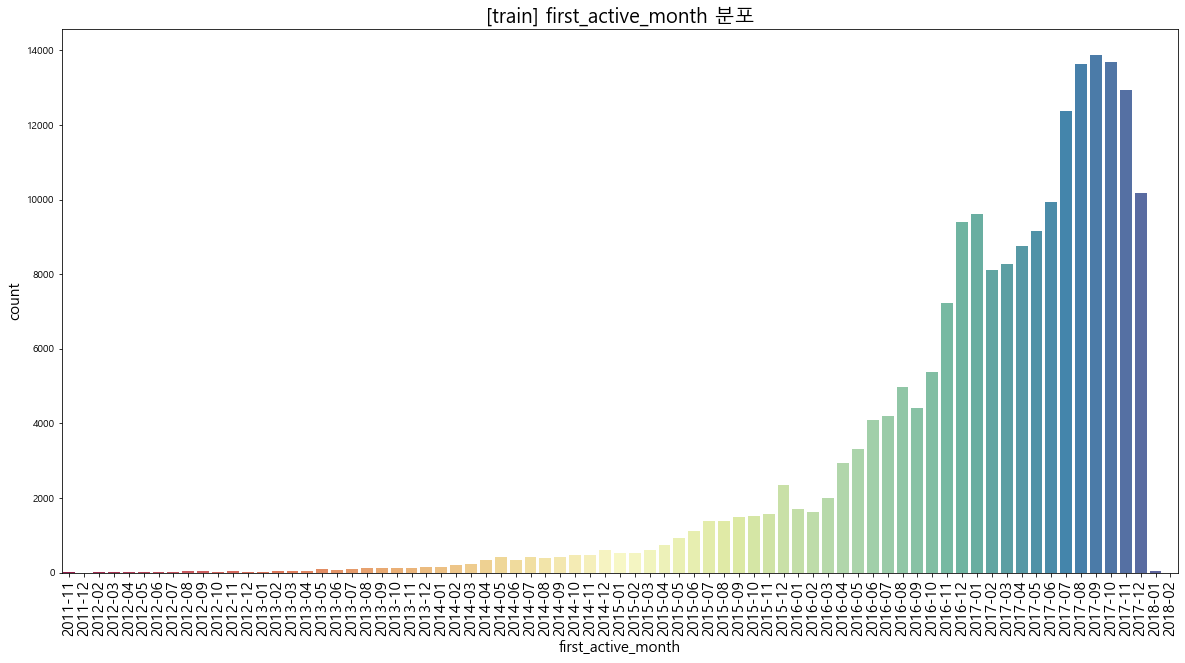

In [134]:
### first_active_month 
plt.figure(figsize=(20,10))
plt.title("[train] first_active_month 분포",size=20)
first_active_month=sns.countplot(x=train.first_active_month,palette='Spectral',
            order = sorted(train.first_active_month.value_counts().index))
first_active_month.set_xticklabels(first_active_month.get_xticklabels(), rotation=90, size=15)

[Text(0, 0, '2011-11'),
 Text(0, 0, '2011-12'),
 Text(0, 0, '2012-01'),
 Text(0, 0, '2012-02'),
 Text(0, 0, '2012-03'),
 Text(0, 0, '2012-04'),
 Text(0, 0, '2012-05'),
 Text(0, 0, '2012-06'),
 Text(0, 0, '2012-07'),
 Text(0, 0, '2012-08'),
 Text(0, 0, '2012-09'),
 Text(0, 0, '2012-10'),
 Text(0, 0, '2012-11'),
 Text(0, 0, '2012-12'),
 Text(0, 0, '2013-01'),
 Text(0, 0, '2013-02'),
 Text(0, 0, '2013-03'),
 Text(0, 0, '2013-04'),
 Text(0, 0, '2013-05'),
 Text(0, 0, '2013-06'),
 Text(0, 0, '2013-07'),
 Text(0, 0, '2013-08'),
 Text(0, 0, '2013-09'),
 Text(0, 0, '2013-10'),
 Text(0, 0, '2013-11'),
 Text(0, 0, '2013-12'),
 Text(0, 0, '2014-01'),
 Text(0, 0, '2014-02'),
 Text(0, 0, '2014-03'),
 Text(0, 0, '2014-04'),
 Text(0, 0, '2014-05'),
 Text(0, 0, '2014-06'),
 Text(0, 0, '2014-07'),
 Text(0, 0, '2014-08'),
 Text(0, 0, '2014-09'),
 Text(0, 0, '2014-10'),
 Text(0, 0, '2014-11'),
 Text(0, 0, '2014-12'),
 Text(0, 0, '2015-01'),
 Text(0, 0, '2015-02'),
 Text(0, 0, '2015-03'),
 Text(0, 0, '201

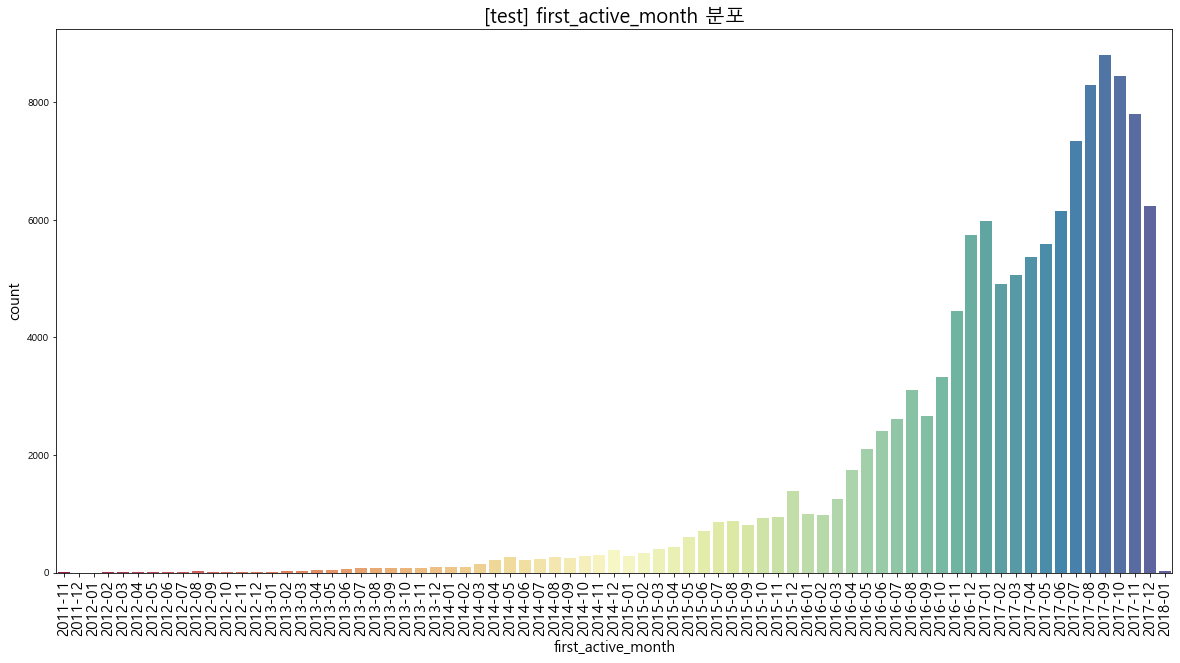

In [17]:
### first_active_month 
plt.figure(figsize=(20,10))
plt.title("[test] first_active_month 분포",size=20)
first_active_month=sns.countplot(x=test.first_active_month,palette='Spectral',
            order = np.sort(test.first_active_month.value_counts().index))
first_active_month.set_xticklabels(first_active_month.get_xticklabels(), rotation=90, size=15)

### feature 1/2/3

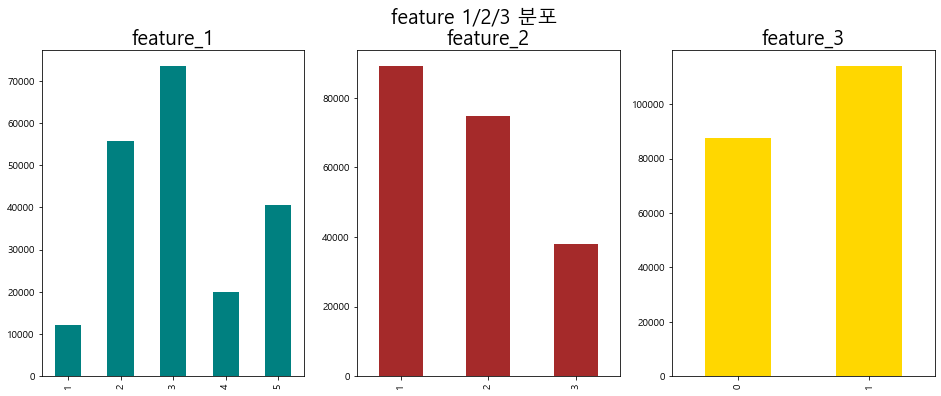

In [18]:
fig, ax = plt.subplots(1, 3, figsize = (16, 6));
train['feature_1'].value_counts().sort_index().plot(kind='bar', ax=ax[0], color='teal', title='feature_1');
train['feature_2'].value_counts().sort_index().plot(kind='bar', ax=ax[1], color='brown', title='feature_2');
train['feature_3'].value_counts().sort_index().plot(kind='bar', ax=ax[2], color='gold', title='feature_3');
plt.suptitle('feature 1/2/3 분포',size=20);

### target

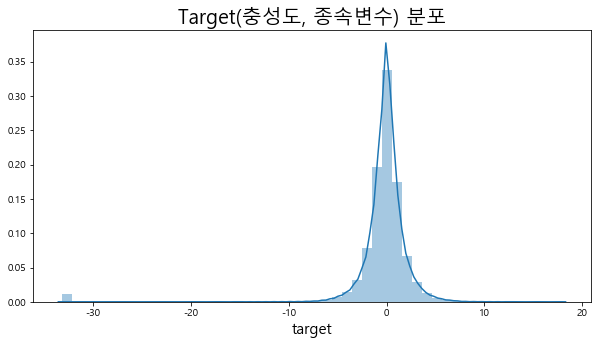

In [19]:
plt.figure(figsize=(10,5))
plt.title("Target(충성도, 종속변수) 분포",size=20)
sns.distplot(train.target)

In [20]:
print('-30 이하 target 값은 {} 개.'.format(len(train.loc[train.target < -30])))

-30 이하 target 값은 2207 개.


## 2. transactions(historical / new)

In [21]:
history_trans.head()
history_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           object
category_2              float64
state_id                int64
subsector_id            int64
dtypes: float64(2), int64(6), object(6)
memory usage: 3.0+ GB


In [22]:
colname=[]
na_count=[]

for column in history_trans.columns.values:
    colname.append(column)
    na_count.append(history_trans['{}'.format(column)].isna().sum())
    
                    
col=pd.DataFrame(colname,columns=['열이름'])
count=pd.DataFrame(na_count,columns=['NA개수'])


na_df=pd.concat([col,count],axis=1)
na_df['NA비율(%)']=na_df['NA개수']/len(history_trans.card_id)*100
na_df

,열이름,NA개수,NA비율(%)
0,authorized_flag,0,0.000000
1,card_id,0,0.000000
2,city_id,0,0.000000
3,category_1,0,0.000000
4,installments,0,0.000000
5,category_3,178159,0.611970
6,merchant_category_id,0,0.000000
7,merchant_id,138481,0.475678
8,month_lag,0,0.000000
9,purchase_amount,0,0.000000


In [23]:
print('Purchase date 기간:',min(history_trans.purchase_date),'~',max(history_trans.purchase_date))

Purchase date 기간: 2017-01-01 00:00:08 ~ 2018-02-28 23:59:51


### month_lag

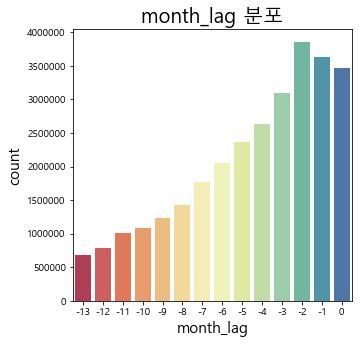

In [24]:
### first_active_month 
plt.figure(figsize=(5,5))
plt.title("month_lag 분포",size=20)
month_lag=sns.countplot(x=history_trans.month_lag,palette='Spectral')
#first_active_month.set_xticklabels(first_active_month.get_xticklabels(), rotation=90, size=15)

### authorized_flag

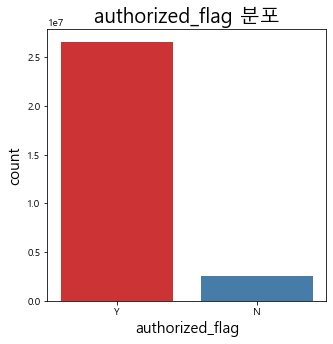

In [25]:
### authorized_flag
plt.figure(figsize=(5,5))
plt.title("authorized_flag 분포",size=20)
authorized_flag=sns.countplot(x=history_trans.authorized_flag,palette='Set1')
#city_id.set_xticklabels(city_id.get_xticklabels(), rotation=90, size=15)

In [26]:
print(len(history_trans.loc[history_trans.authorized_flag=='Y']))
print(len(history_trans.loc[history_trans.authorized_flag!='Y']))

26595452
2516909


### category_3

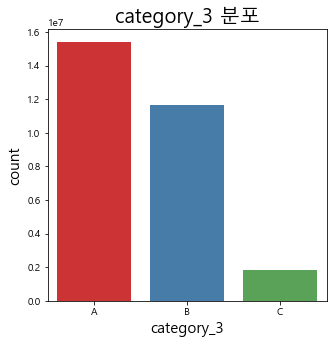

In [27]:
### category_3
plt.figure(figsize=(5,5))
plt.title("category_3 분포",size=20)
category_3=sns.countplot(x=history_trans.category_3,palette='Set1')
#city_id.set_xticklabels(city_id.get_xticklabels(), rotation=90, size=15)

In [28]:
history_trans.category_3.isna().sum()

178159

### installments

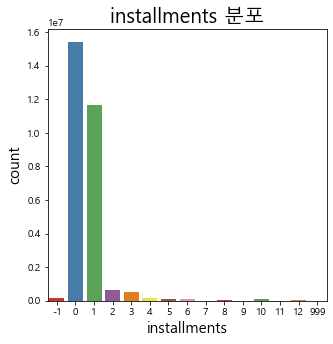

In [29]:
### installments
plt.figure(figsize=(5,5))
plt.title("installments 분포",size=20)
installments=sns.countplot(x=history_trans.installments,palette='Set1')
#city_id.set_xticklabels(city_id.get_xticklabels(), rotation=90, size=15)

### category_1

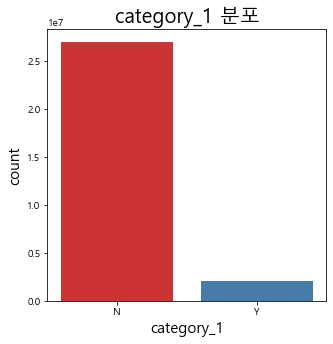

In [30]:
### category_1
plt.figure(figsize=(5,5))
plt.title("category_1 분포",size=20)
category_1=sns.countplot(x=history_trans.category_1,palette='Set1')
#city_id.set_xticklabels(city_id.get_xticklabels(), rotation=90, size=15)

### merchant_category_id

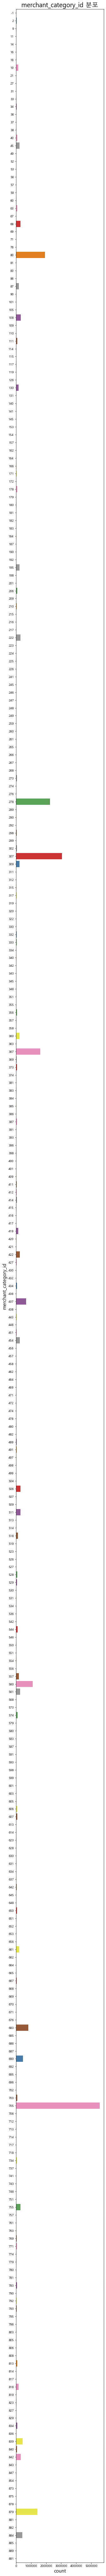

In [31]:
### merchant_category_id
plt.figure(figsize=(5,150))
plt.title("merchant_category_id 분포",size=20)
merchant_category_id=sns.countplot(y=history_trans.merchant_category_id,palette='Set1')
#city_id.set_xticklabels(city_id.get_xticklabels(), rotation=90, size=15)

In [32]:
pd.DataFrame(history_trans.merchant_category_id.value_counts())

,merchant_category_id
705,5554009
307,3057930
278,2254227
80,1929413
367,1608239
...,...
311,1
322,1
882,1
86,1


### subsector_id

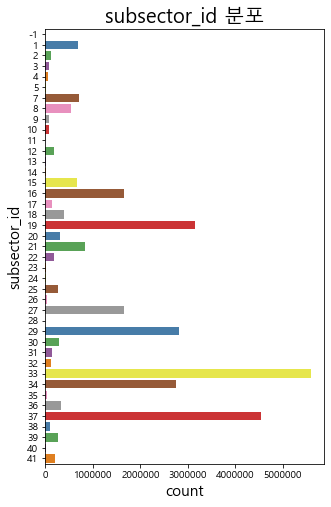

In [33]:
### subsector_id
plt.figure(figsize=(5,8))
plt.title("subsector_id 분포",size=20)
subsector_id=sns.countplot(y=history_trans.subsector_id,palette='Set1')
#city_id.set_xticklabels(city_id.get_xticklabels(), rotation=90, size=15)

In [34]:
pd.DataFrame(history_trans.subsector_id.value_counts())

,subsector_id
33,5594146
37,4531755
19,3147440
29,2813095
34,2759431
27,1658301
16,1651384
21,837612
7,711977
1,695263


In [35]:
print(len(history_trans.subsector_id.value_counts()))

41


### merchant_id

In [36]:
pd.DataFrame(history_trans.merchant_id.value_counts())

,merchant_id
M_ID_00a6ca8a8a,1115097
M_ID_e5374dabc0,428619
M_ID_9139332ccc,361385
M_ID_50f575c681,183894
M_ID_fc7d7969c3,177040
...,...
M_ID_1678ac856a,1
M_ID_ede7cfeb71,1
M_ID_65c8865e64,1
M_ID_9256828249,1


In [37]:
history_trans.merchant_id.isna().sum()

138481

### purchase_amount

In [38]:
pd.DataFrame(history_trans.purchase_amount.value_counts())

,purchase_amount
-0.671775,687283
-0.716855,600414
-0.701828,510925
-0.731881,417335
-0.596643,389066
...,...
23.065906,1
2.941214,1
19.409655,1
9.262252,1


In [39]:
print('표준화된 구매량 : 최소 {}회 ~ 최대 {}회'.
      format(min(history_trans.purchase_amount),max(history_trans.purchase_amount)))

표준화된 구매량 : 최소 -0.7469078회 ~ 최대 6010603.9717525회


In [40]:
history_trans.purchase_amount.isna().sum()

0

### city_id

In [41]:
pd.DataFrame(history_trans.city_id.value_counts())

,city_id
69,4835441
-1,2478624
19,1151077
158,1113013
17,971714
...,...
319,1645
92,758
273,620
316,149


In [42]:
history_trans.city_id.isna().sum()

0

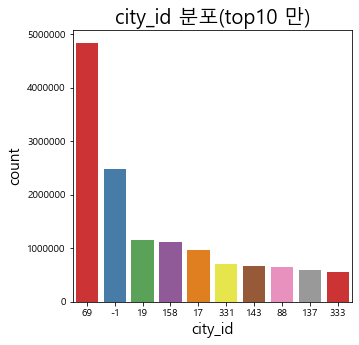

In [43]:
### city_id
plt.figure(figsize=(5,5))
plt.title("city_id 분포(top10 만)",size=20)
city_id=sns.countplot(x=history_trans.city_id,palette='Set1',
                     order=history_trans.city_id.value_counts().index[0:10])
#city_id.set_xticklabels(city_id.get_xticklabels(), rotation=90, size=15)

### state_id

In [44]:
pd.DataFrame(history_trans.state_id.value_counts())

,state_id
9,10568881
-1,2652864
16,2143420
15,2079255
5,1655124
19,1204287
20,1141197
22,971714
21,929594
4,840820


In [45]:
history_trans.city_id.isna().sum()

0

In [46]:
len(history_trans.state_id.value_counts())

25

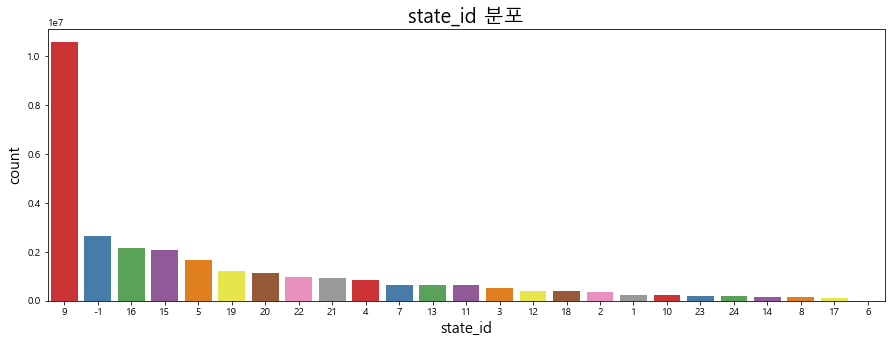

In [47]:
### state_id
plt.figure(figsize=(15,5))
plt.title("state_id 분포",size=20)
state_id=sns.countplot(x=history_trans.state_id,palette='Set1',
                     order=history_trans.state_id.value_counts().index)
#city_id.set_xticklabels(city_id.get_xticklabels(), rotation=90, size=15)

### category_2

In [48]:
pd.DataFrame(history_trans.category_2.value_counts())

,category_2
1.0,15177199
3.0,3911795
5.0,3725915
4.0,2618053
2.0,1026535


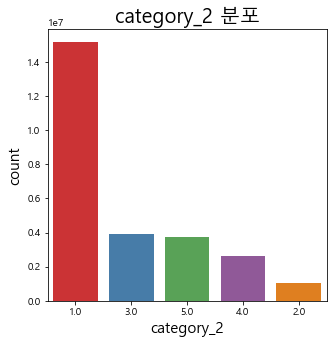

In [49]:
### category_2
plt.figure(figsize=(5,5))
plt.title("category_2 분포",size=20)
category_2=sns.countplot(x=history_trans.category_2,palette='Set1',
                     order=history_trans.category_2.value_counts().index)
#city_id.set_xticklabels(city_id.get_xticklabels(), rotation=90, size=15)

## 3. merchants